### Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Постановка задачи

В крупном магазине продуктовой сети появилась необходимость автоматического прогнозирования продаж товаров с целью более эффективного управления складскими запасами. Для этого нами были получены тестовые данные на 1 товар одного магазина сети за 2014 - 2018 гг. По информации от руководства сети, на продажи предоставленного товара не влияют продажи других товаров в магазине. Также известно, что товар все это время был в наличии в магазине.

### Загрузка данных

In [3]:
df=pd.read_csv('data_for_regression.csv', sep=';')
df.head()

date  price   T       sales
0  2014-01-01  126.9 -27   87.110569
1  2014-01-02  126.9 -25  117.233120
2  2014-01-03  126.9 -20  109.978085
3  2014-01-04  126.9 -21  114.134202
4  2014-01-05  115.9 -24  125.839838

In [4]:
df.columns

Index(['date', 'price', 'T', 'sales'], dtype='object')

In [5]:
# Преобразуем поле date в тип дата
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

### Данные

In [6]:
# Объем данных
df.shape

(1826, 4)

In [7]:
# Статистика
df.describe()

price            T        sales
count  1826.000000  1826.000000  1826.000000
mean    109.736254     0.841731   207.388282
std      24.062636    16.843083    95.151028
min      69.900000   -34.000000    56.443239
25%      87.900000   -15.000000   138.657888
50%     105.900000     1.000000   185.898634
75%     124.900000    16.000000   253.047532
max     157.900000    32.000000   860.714197

Text(0, 0.5, 'Продажи, шт')

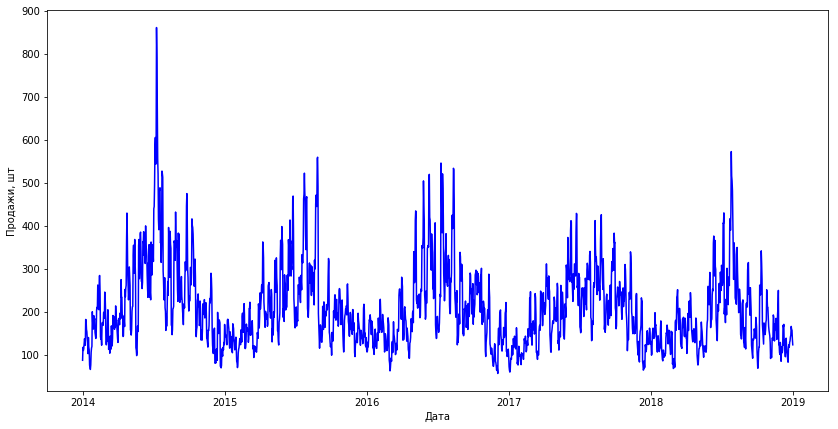

In [8]:
# График продаж за 2014 - 2018 гг.
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

Text(0, 0.5, 'Продажи, шт')

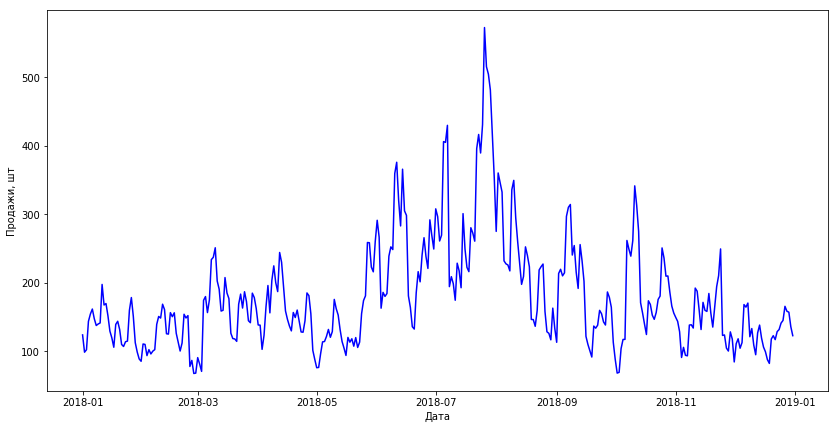

In [9]:
# График продаж за 2018 г.
plt.figure(figsize=(14,7))
plt.plot(df[df['date']>='2018-01-01']['date'], df[df['date']>='2018-01-01']['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

### Генерация признаков даты

In [10]:
df['dw']=pd.DatetimeIndex(df.date).weekday+1
df['month']=pd.DatetimeIndex(df.date).month
df['year']=pd.DatetimeIndex(df.date).year

### Целевая переменная

(array([183., 533., 425., 319., 165.,  94.,  53.,  24.,  18.,   8.,   1.,
          1.,   0.,   1.,   1.]),
 array([ 56.44323912, 110.06130298, 163.67936684, 217.2974307 ,
        270.91549456, 324.53355842, 378.15162228, 431.76968614,
        485.38775   , 539.00581386, 592.62387772, 646.24194158,
        699.86000544, 753.4780693 , 807.09613316, 860.71419702]),
 <a list of 15 Patch objects>)

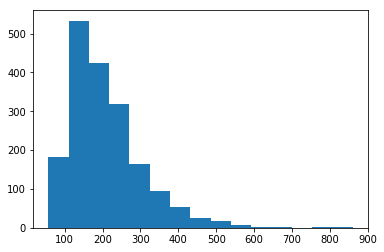

In [11]:
plt.hist(df['sales'], bins=15)

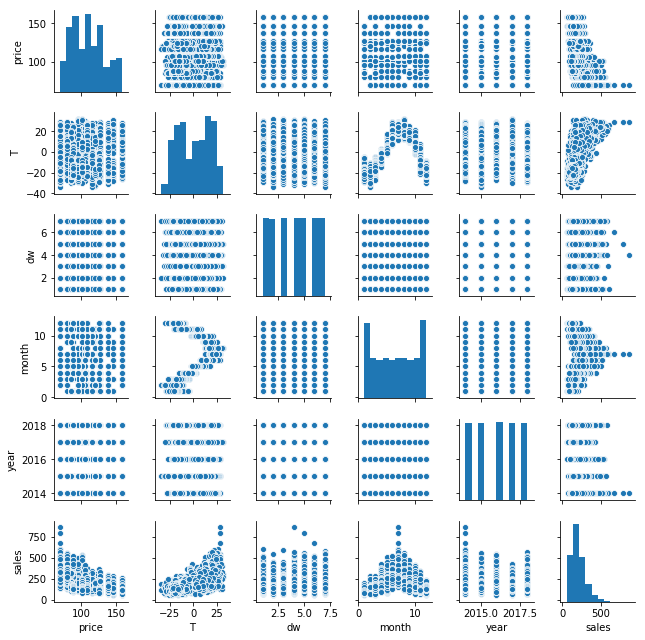

In [12]:
# Матрица графиков рассеяния геопризнаков и категории продаж
col=['price', 'T', 'dw', 'month', 'year', 'sales']
sns.pairplot(df[col], size=1.5)

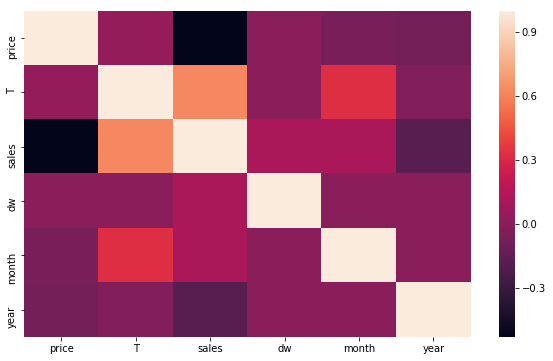

In [13]:
# Корреляционная матрица
data_corr=df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

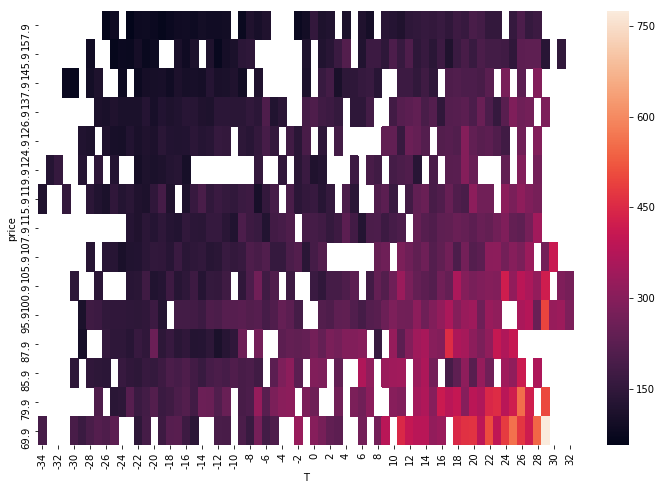

In [14]:
# Зависимость от долготы и широты
df_copy=df.copy()
# df_copy['longitude_round']=np.round(df_copy['longitude'], 0)
# df_copy['latitude_round']=np.round(df_copy['latitude'], 0)

plt.figure(figsize = (12,8))
sns.heatmap(df_copy.pivot_table('sales', index=['price'], 
                            columns=['T'],  aggfunc='mean').copy()
                                    .sort_values(by='price', ascending=False))

### Подготовка данных для обучения модели

In [15]:
# Разделение признаков и целевой переменной. Удаление неинформативных признаков.

X=df[[
    'price', 
    'T', 
    'dw', 
    'month', 
    'year'
    ]]

Y=df['sales']

### Разделение данных на обучающую и тестовую выборку

In [16]:
x_lim=int(len(X)*0.80)

X_train=X[0:x_lim].copy()
Y_train=Y[0:x_lim].copy()
X_test=X[x_lim+1:].copy()
Y_test=Y[x_lim+1:].copy()

### Типы данных

In [17]:
# Группировка по дням недели
df.groupby(by='dw').mean()[['sales']]

sales
dw            
1   199.066736
2   179.044581
3   177.761544
4   237.697880
5   232.804503
6   221.693851
7   203.540286

In [18]:
# Разделение данных на вещественные и категориальные

X_train_v=X_train[['price', 'T', 'year']]
X_train_k=X_train[['dw', 'month']]

X_test_v=X_test[['price', 'T', 'year']]
X_test_k=X_test[['dw', 'month']]

In [19]:
# Обработка вещественных данных

from sklearn.preprocessing import StandardScaler

ss=StandardScaler()

X_train_v=ss.fit_transform(X_train_v)
X_test_v=ss.transform(X_test_v)

print('Минимум и максимум обучающего набора: ', X_train_v.min(), X_train_v.max())
print('Минимум и максимум тестового набора: ', X_test_v.min(), X_test_v.max())

Минимум и максимум обучающего набора:  -2.0773119583706046 1.997624828871071
Минимум и максимум тестового набора:  -1.7827779627969456 2.2379076059289975


In [20]:
# Обработка категориальных данных

from sklearn.preprocessing import OneHotEncoder

one=OneHotEncoder(sparse=False)
one.fit(X_train_k)
X_train_k=one.transform(X_train_k)
X_test_k=one.transform(X_test_k)

In [21]:
# Объединяем вещественные и категориальные данные

X_train_all=np.hstack((X_train_v, X_train_k))
X_test_all=np.hstack((X_test_v, X_test_k))

In [22]:
X_train_all.shape

(1460, 22)

### Базовое решение

В качестве базового решения используем методику ручного прогнозирования, используемого в сети: средние продажи за последние 30 дней.

In [23]:
Y_mean=Y_test.rolling(window=30).mean()

In [24]:
from sklearn.metrics import mean_absolute_error

print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Y_mean[30:]), 2))
print('Среднее значение продаж: ', np.round(Y_test[30:].mean(), 2))

Среднее абсолютное отклонение:  49.28
Среднее значение продаж:  184.07


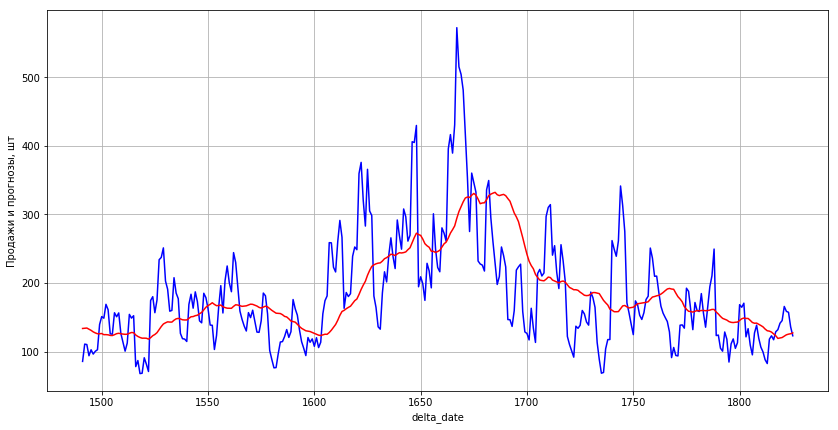

In [25]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], 'b')
plt.plot(Y_mean[30:], 'r')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

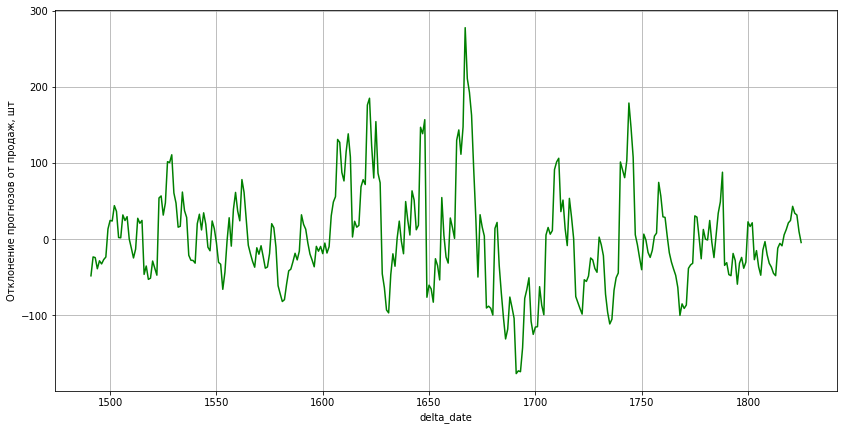

In [26]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Y_mean[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

### Линейная регрессия

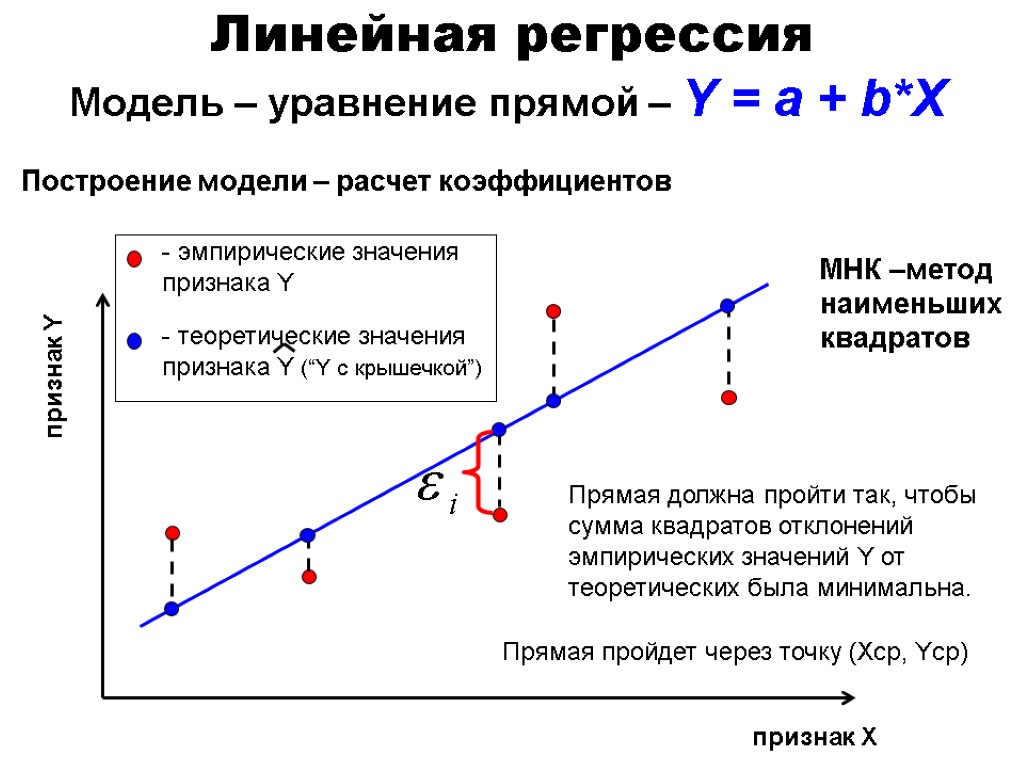

In [27]:
Image("linear_regression.jpg", width=500, height=500)

In [28]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train_all, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
Pred_lr_train=lr.predict(X_train_all)
Pred_lr_test=lr.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_test[30:]), 2))

Среднее абсолютное отклонение:  28.18
Среднее абсолютное отклонение:  24.94


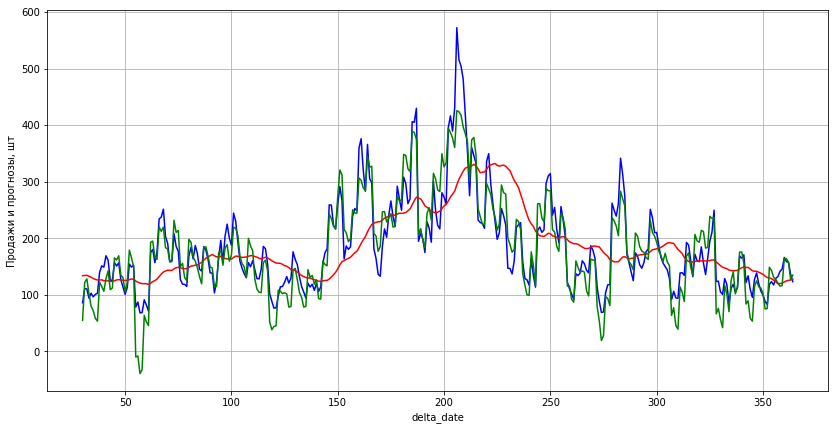

In [30]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Y_mean[30:], 'r')
plt.plot(x[30:], Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

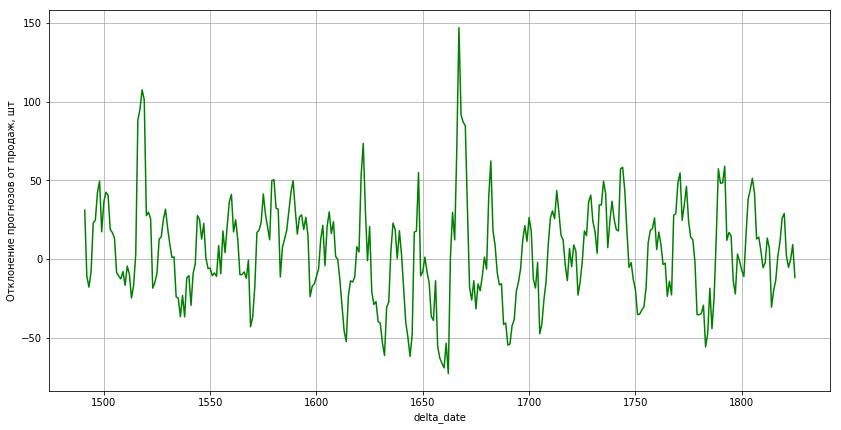

In [31]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

### Регуляризация

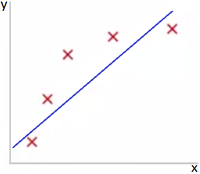

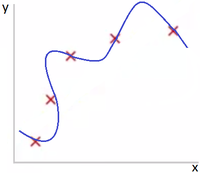

In [32]:
from IPython.display import display

i1=Image("reg1.png", width=250, height=250)
i2=Image("reg2.png", width=250, height=250)
i3=Image("reg3.png", width=250, height=250)

display(i1, i2, i3)

In [33]:
# Гребневая регрессия (L2 - регуляризация)

from sklearn.linear_model  import Ridge

lr_ridge=Ridge(alpha=10)
lr_ridge.fit(X_train_all, Y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
Pred_lr_ridge_train=lr_ridge.predict(X_train_all)
Pred_lr_ridge_test=lr_ridge.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_ridge_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_ridge_test[30:]), 2))

Среднее абсолютное отклонение:  28.33
Среднее абсолютное отклонение:  24.65


In [35]:
# Лассо регрессия (L1 - регуляризация)

from sklearn.linear_model  import Lasso

lr_lasso=Lasso(alpha=0.15)
lr_lasso.fit(X_train_all, Y_train)

Lasso(alpha=0.15, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
Pred_lr_lasso_train=lr_lasso.predict(X_train_all)
Pred_lr_lasso_test=lr_lasso.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_lasso_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_lasso_test[30:]), 2))

Среднее абсолютное отклонение:  28.25
Среднее абсолютное отклонение:  24.73


In [37]:
# Эластичная регрессия (L1 и L2 - регуляризация)

from sklearn.linear_model  import ElasticNet

lr_elastic=ElasticNet(alpha=0.05, l1_ratio=0.005)
lr_elastic.fit(X_train_all, Y_train)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.005,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
Pred_lr_elastic_train=lr_elastic.predict(X_train_all)
Pred_lr_elastic_test=lr_elastic.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_elastic_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_elastic_test[30:]), 2))

Среднее абсолютное отклонение:  29.08
Среднее абсолютное отклонение:  23.7


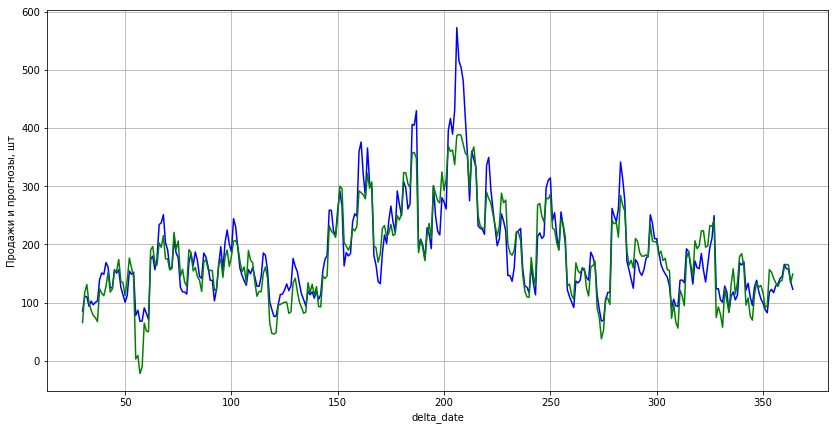

In [39]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Pred_lr_elastic_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

## Статистические методы прогнозирования временных рядов

In [40]:
from scipy import stats
import statsmodels.api as sm

#### Индексация данных времеными метками

In [41]:
df=pd.read_csv('data_for_regression.csv', sep=';', index_col='date')
df.head()

price   T       sales
date                             
2014-01-01  126.9 -27   87.110569
2014-01-02  126.9 -25  117.233120
2014-01-03  126.9 -20  109.978085
2014-01-04  126.9 -21  114.134202
2014-01-05  115.9 -24  125.839838

In [42]:
x_lim=int(len(X)*0.80)

Train=df[0:x_lim].copy()
Test=df[x_lim+1:].copy()

#### Проверка стационарности временного ряда

In [43]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales), freq=365).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

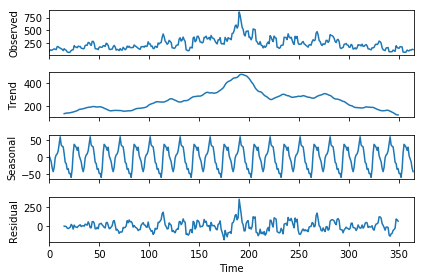

In [44]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales[:365]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

#### Преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: -0.020020
Критерий Дики-Фуллера: p=0.004674


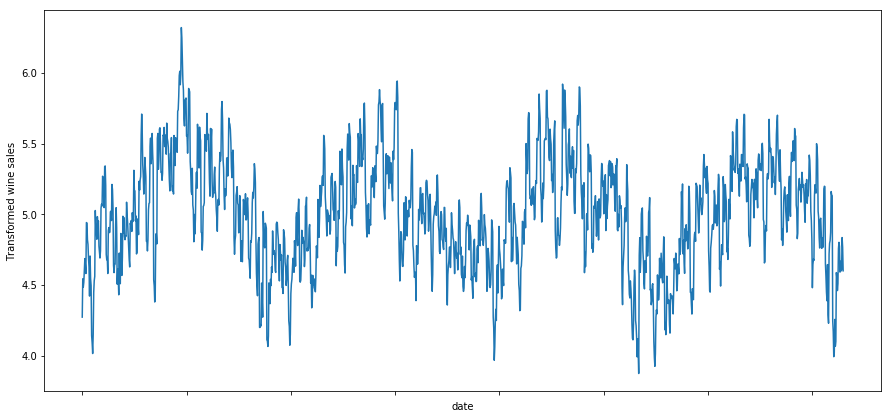

In [45]:
Train['sales_box'], lmbda = stats.boxcox(Train.sales)
plt.figure(figsize=(15,7))
Train.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box)[1])

#### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x504 with 0 Axes>

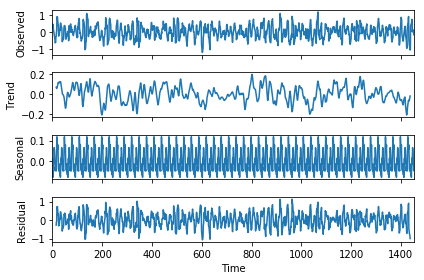

In [46]:
Train['sales_box_diff'] = Train.sales_box - Train.sales_box.shift(7)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(np.array(Train.sales_box_diff[7:]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box_diff[7:])[1])

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

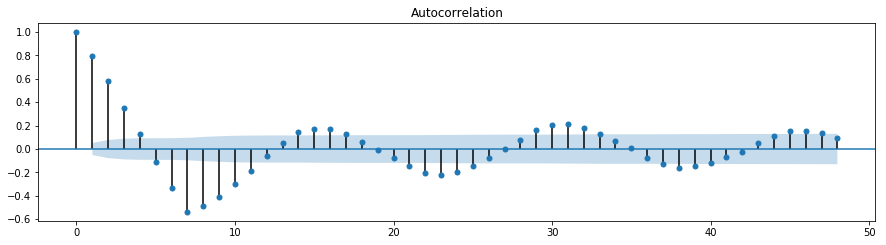

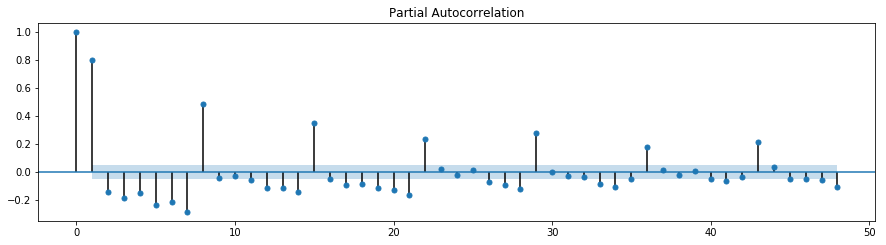

In [47]:
plt.figure(figsize=(15,8))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(Train.sales_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(Train.sales_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [48]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [49]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [50]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(Train.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
CPU times: user 7min 24s, sys: 7.42 s, total: 7min 31s
Wall time: 3min 11s


In [51]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
35  (2, 2, 1, 1) -824.225483
43  (3, 1, 1, 1) -822.656164
31  (2, 1, 1, 1) -821.664295
51  (4, 1, 1, 1) -821.076131
23  (1, 2, 1, 1) -819.592453


In [52]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                 1460
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 419.113
Date:                            Fri, 15 Feb 2019   AIC                           -824.225
Time:                                    16:15:28   BIC                           -787.285
Sample:                                01-01-2014   HQIC                          -810.439
                                     - 12-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4366      0.149      9.666      0.000       1.145       1.728
ar.L2         -0.5642      0.112   

Критерий Стьюдента: p=0.158344
Критерий Дики-Фуллера: p=0.000000


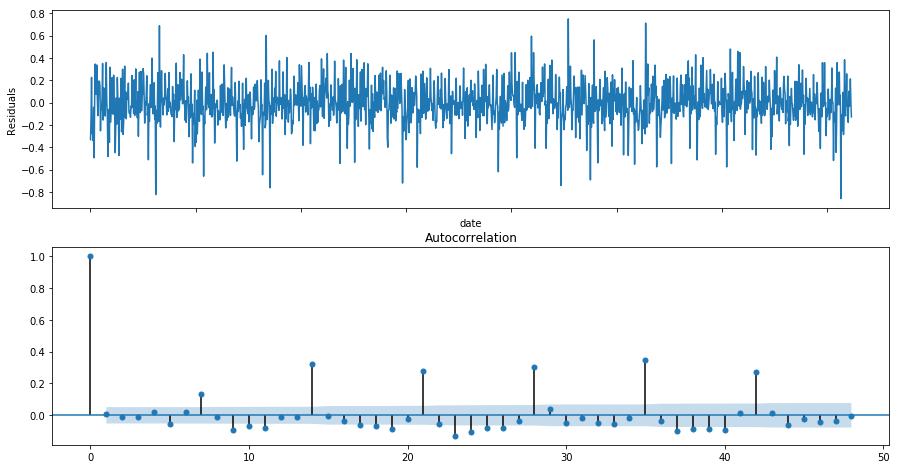

In [53]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [54]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

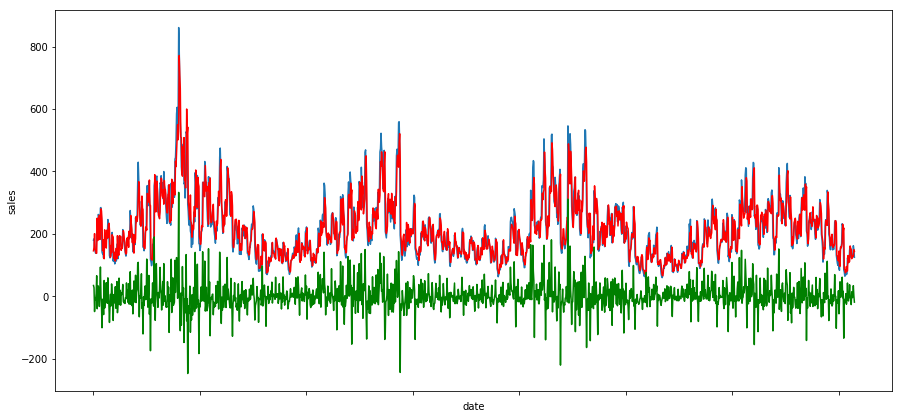

In [55]:
Train['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
Train.sales[30:].plot()
Train.model[30:].plot(color='r')
(Train.sales[30:] - Train.model[30:]).plot(color='g')
plt.ylabel('sales')
plt.show()

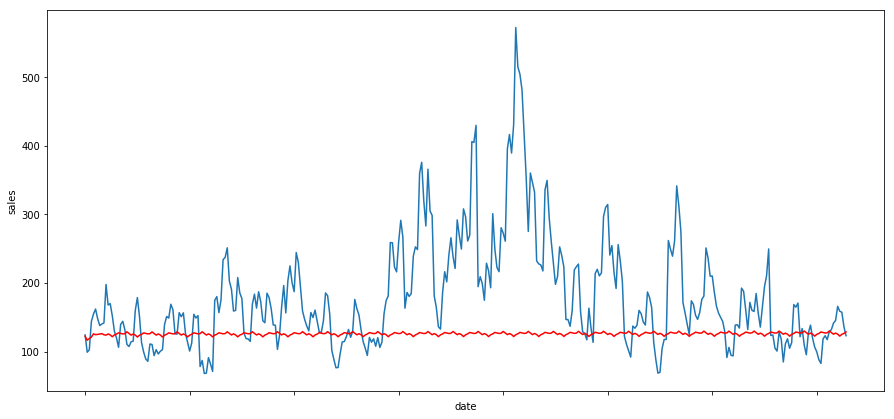

In [56]:
Test['model'] = invboxcox(best_model.predict(start=1461, end=(1461+364)), lmbda)
plt.figure(figsize=(15,7))
Test.sales.plot()
Test.model.plot(color='r')
plt.ylabel('sales')
plt.show()

## Домашнее задание

1. Реализовать метод Prophet для представленных данных. Получить прогноз. Оценить точность.
2. Реализовать метод "Дерево регрессии". Получить прогноз. Оценить точность.
3. Изучить выше представленные методы. Попытаться улучшить прогноз с помощью генерации новых признаков, учета нелинейных зависимостей в признаках, подбора оптимальных гиперпараметров или другими методами.